# MATH3976 Project: SimpleCircuits.jl

David Rapisarda

SID: 440429320

There are two dependencies - [DataStructures.jl](https://github.com/JuliaLang/DataStructures.jl) and [Sundials.jl](https://github.com/JuliaLang/Sundials.jl). (I installed these with `Pkg.add("DataStructures")` and `Pkg.add("Sundials")` - for the latter, the backend installed automatically on 64-bit Linux.)

In [1]:
include("SimpleCircuits.jl")
using SimpleCircuits
using PyPlot
versioninfo()

Julia Version 0.4.5
Commit 2ac304d (2016-03-18 00:58 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i5-4670 CPU @ 3.40GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACK NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


This document is split into three parts: in the first, the implementation details of the simulator are covered. In the second part, some examples of the simulator in use are shown. In the last part, some avenues for further work are discussed.

## Originality

Simulation of analog electronic circuits dates back to the first release of SPICE in 1973, and considerable effort has been put into the development of such simulators since. The mathematical methods used in this project are not unique - further, there is another circuit simulator package implemented in julia, [ACME.jl](https://github.com/HSU-ANT/ACME.jl), which has a focus on generating state-space model descriptions of circuits for transient analysis. For constructing circuits via specifying connections, a similar interface to ACME has been used (`connect(circ, ...)`) - but the internals here are quite different.

However, one area which may be considered an original contribution is the combined use of Julia's metaprogramming features and it's JIT compiler to generate efficient functions for the system of equations and corresponding Jacobian (described below).

## Part 1: Implementation Details

The general approach taken here to solving circuits is to generate a system of equations of the form:

$$ \vec{F}(\vec{v}, \vec{I}) = 0 $$

where $\vec{v}$ is the vector of node voltages of the circuit, and $\vec{I}$ is the vector of "dummy" currents - currents through components that do not specify a DC IV relation (more on that later). The generated system should have the same number of equations as variables.

From here on, the system will be written as $\vec{F}(\vec{x})$ with $\vec{x} = [\vec{v}; \: \vec{I}]$.

To solve the system efficiently, we also need to generate an expression for the Jacobian matrix of the above system:

$$ \vec{J}_{ij}(\vec{x}) = \frac {\partial F_i} {\partial x_j} $$

If for a given circuit we have efficient functions for computing these two quantities at values of $\vec{x}$, then we can apply a multidimensional root finding procedure (such as the Newton-Raphson method, which requires the system function and it's Jacobian) find the circuit's operating point. An iteration of the Newton-Raphson method is defined implicitly as:

$$ (\vec{J}(\vec{x}_k))(\vec{x}_{k+1} - \vec{x}_k) = -\vec{F}(\vec{x}_k)$$

To generate both of these, nodal analysis can be used, provided we have some knowledge of how the current through a given port on each device relates to the voltages on its ports. 

### DC IV Relations

Each device must specify either:

1. The current going into a given port as a function of the port voltages, $I(p, \vec{v})$, or
2. A direct relationship between the voltages

Note that this implies that the ports of components are uniquely stored, even if they are non-polarized like resistors and capacitors. 

In the second case, an additional variable will be assigned to the current through that component, termed a dummy current variable.  For the following relations, the voltage on port $p_i$ is $v_i$. 

For the symbolic implementation of these relations, see `dciv_relations.jl`.

#### Resistors

The relation is:

$$ I(p_1, v_1, v_2) = \frac{v_1 - v_2} {R} $$

$$ I(p_2, v_1, v_2) = -\frac{v_1 - v_2} {R} $$

which follows from the relation $V = IR$.

#### DC Voltage Sources

For a DC voltage source, we have the relation $ v_1 - v_2 - V = 0 $ - that is, we specify the difference in voltage between the two ports as a constant value. Since this is *not* an expression for the current in terms of the port voltages, a dummy current variable will be added for this component. 

#### Capacitors and Inductors

The relationships for capacitors and inductors are differential - for a capacitor we have

$$ I(p_1, v_1, v_2) = C\frac{d}{dt}(v_1 - v_2) $$

However, we're considering DC (steady state) relationships here - so the time derivative will be zero. Since we have an expression for the current, we don't need a dummy current here.

For an inductor we have (where $i$ is the current from $p_1$ to $p_2$)

$$ v_1 - v_2 = L\frac{di}{dt} $$

Again, we're considering steady-state solutions, so $\frac{di}{dt} = 0$ - so $v_1 - v_2 = 0$. Like the voltage source, this does not provide an expression for the current, so a dummy current variable is used for this.

#### PN-Junction Diodes

Things are more interesting with non-linear components. For a silicon semiconductor junction diode we have:

$$ I(p_1, v_1, v_2) = I_S (\exp(\frac{v_1 - v_2} {nV_T}) - 1) $$

with $v_1$ derivative:

$$ \frac{d}{dv_1}(I(p_1, v_1, v_2)) = \frac{I_S}{nV_T} \exp(\frac{v_1 - v_2}{nV_T}) $$

Now, beyond a certain voltage, the diode behaves essentially like a near-zero resistance - so that a very small increase in voltage causes a very large increase in current. This causes problems with the numerical stability of Newton-Raphson

## Part 2: Examples

### Example 1: Voltage divider

<img src="img/example1.png" />

This is the simplest example of any interest: two resistors connected in series, excited by a DC voltage source. 

In [2]:
circ = Circuit()
r1 = Resistor(5e+3)
r2 = Resistor(10e+3)
vin = DCVoltageSource(5.)
connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)
connect!(circ, r1.p2, r2.p1, "Vout")
connect!(circ, r2.p2, circ.gnd)

cop = op(circ)

Node voltages: 
5.0 <==> node 1
0.0 <==> GND
3.333333333333333 <==> Vout
DCVoltageSource currents: 
0.0003333333333333334 <==> SimpleCircuits.DCVoltageSource("",5.0,port pHigh on a DCVoltageSource connected to node "node 1",port pLow on a DCVoltageSource connected to node "GND")


See what happens when varing the value of R1:

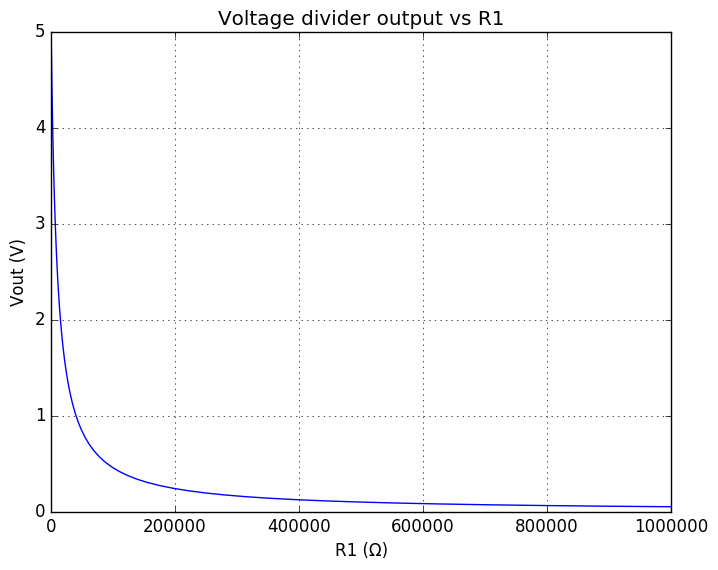

In [3]:
# change the resistance of r1 to a parameter
r1.R = :R
params = Parameters(:R => 1.)
R_range = logspace(1., 6., 100)

# compute the operating point for all values of this parameter
cop = dc_sweep(circ, :R, R_range, params)

grid(b=true, which="major")
title("Voltage divider output vs R1")
xlabel("R1 (Ω)")
ylabel("Vout (V)")
plot(R_range, cop[r1.p2]);

### Example 2: Simple diode circuit

<img src="img/example2.png" />

Linear circuit analysis is not so interesting, since Thevenin's theorem states that for any linear circuit there exists an equivalent circuit, with one voltage source and one resistor, which appears exactly the same as the original circuit seen from some two nodes - so now let's examine a simple non-linear circuit. 

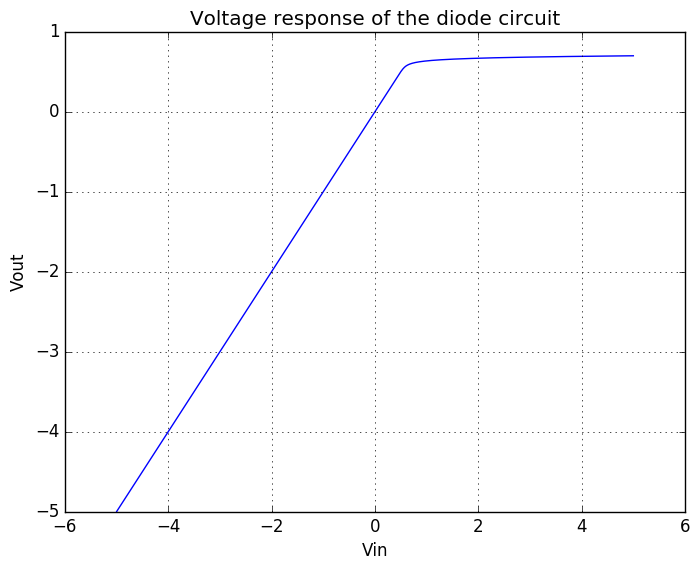

In [4]:
circ = Circuit()
r1 = Resistor(1e+3)
d1 = Diode() # using the default values for a diode

# we will be sweeping over the input voltage
vin = DCVoltageSource(:V)

connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)
connect!(circ, r1.p2, d1.pIn)
connect!(circ, d1.pOut, circ.gnd)

# default value for Vin - it will be overridden when we sweep anyway
params = Parameters(:V => 5.)

V_range = -5.:0.01:5.
cop = dc_sweep(circ, :V, V_range, params)

# plot the voltage on the diode
grid(b=true, which="major")
title("Voltage response of the diode circuit")
xlabel("Vin")
ylabel("Vout")
plot(V_range, cop[r1.p2]);

We can see that the diode in this case acts like a voltage "limiter" at one end - in the limited region, the diode is acting like a short circuit, plus a constant ~$0.7 \textrm{ V}$ voltage drop. This can be extended to form a useful circuit ...

### Example 3: Voltage limiter

<img src="img/example3.png" />

This works the same way as the above circuit does - but now we have two diodes in parallel, facing opposite directions - so the voltage is limited on both sides. For a more interesting result, let's put two diodes in series in one branch, so that the limit on one side should be twice as large as the other side.

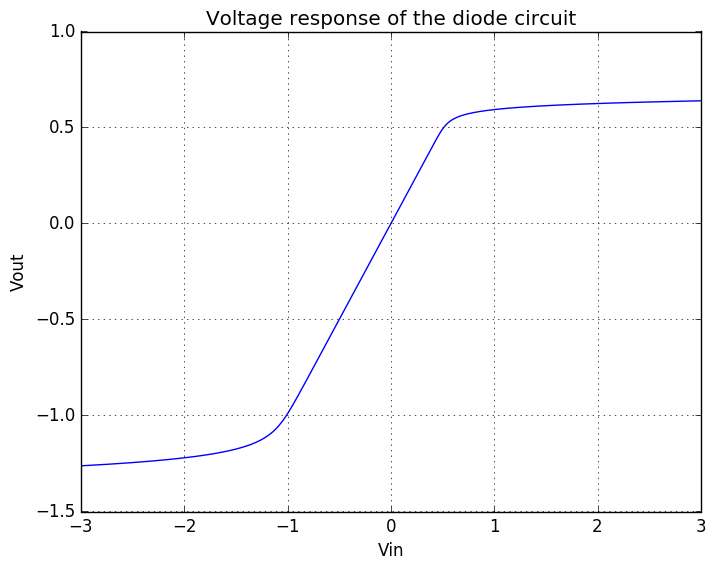

In [5]:
circ = Circuit()
vin = DCVoltageSource(:V)
r1 = Resistor(5e+3)

# the default parameters are reasonable - we could investigate variations in the ideality factor, temperuture,
# saturation current, etc
d1 = Diode()
d2 = Diode()
d3 = Diode()

connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)

# connect the first (single) diode branch
connect!(circ, r1.p2, d1.pIn)
connect!(circ, d1.pOut, circ.gnd)

# connect the second (double) diode branch
connect!(circ, r1.p2, d2.pOut)
connect!(circ, d2.pIn, d3.pOut)
connect!(circ, d3.pIn, circ.gnd)

V_range = -3.:0.01:3.
cop = dc_sweep(circ, :V, V_range, params)

# plot the voltage on the diode
grid(b=true, which="major")
title("Voltage response of the diode circuit")
xlabel("Vin")
ylabel("Vout")
plot(V_range, cop[r1.p2]);

Let's run transient analysis on the above circuit, with a sinusoidal input (note that because there's no components that introduce time derivatives, this is equivalent to a DC sweep):

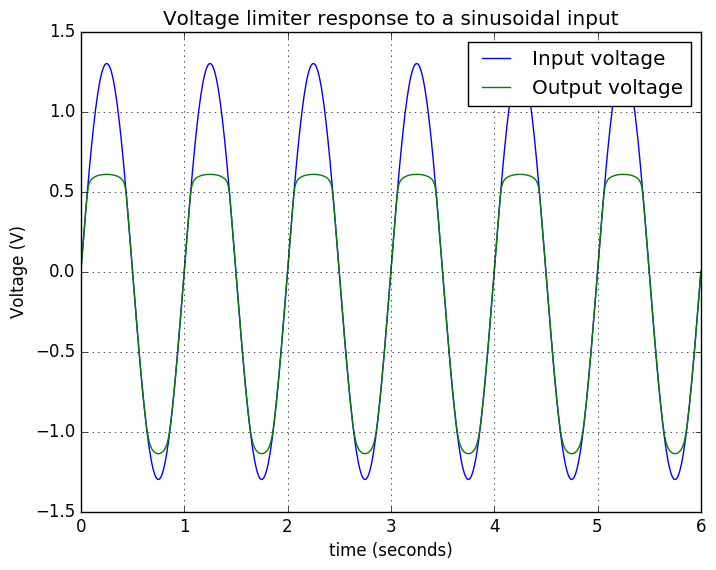

In [6]:
# we have to replace the DCVoltageSource with a VoltageSource - probably a poor design decision there
# disconnect both it's ports
disconnect!(circ, vin.pLow)
disconnect!(circ, vin.pHigh)

# replace it
vin = VoltageSource(:(1.3*sin(2pi * t)))
connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)

# do the analysis
trange = 0.:0.01:6
cop = trans_exp(circ, trange)

grid(b=true, which="major")
title("Voltage limiter response to a sinusoidal input")
xlabel("time (seconds)")
ylabel("Voltage (V)")
plot(trange, cop[vin.pHigh])
plot(trange, cop[r1.p2])
legend(["Input voltage", "Output voltage"]);

### Example 4: Low pass voltage limiter

Now we can extend the above circuit to one that has state by adding a capacitor in parallel with the diodes, forming a low pass filter.

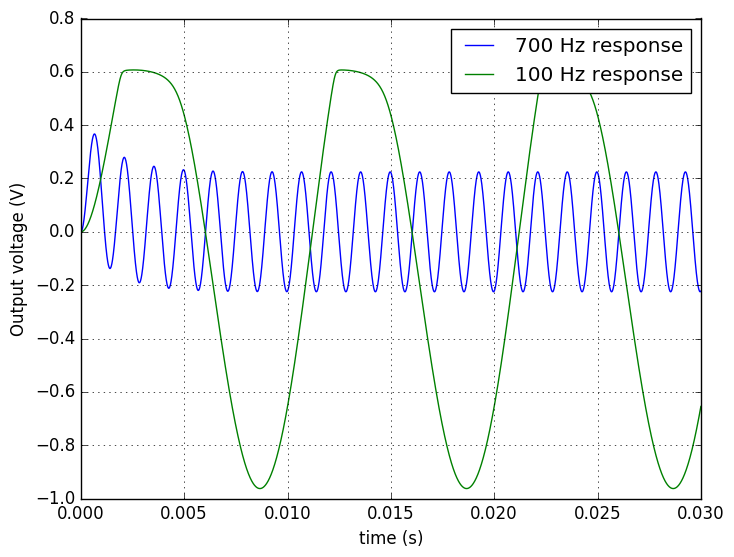

In [7]:
c1 = Capacitor(3e-7)

# connect it across the diode branches
connect!(circ, c1.p1, r1.p2)
connect!(circ, c1.p2, circ.gnd)

# set the input voltage frequency to 700 Hz
f = 0.7e+3
vin.V = :(1.5*sin(2pi*$(f)*t))

# set a small range as appropriate for a high frequency
trange = 0.:0.00001:0.03
cop = trans_exp(circ, trange)

grid(b=true, which="major")
plot(trange, cop[r1.p2])

# now do it again, for a lower frequency
f = 0.1e+3
vin.V = :(1.3*sin(2pi*$(f)*t))

cop = trans(circ, trange)
plot(trange, cop[r1.p2])

legend(["700 Hz response", "100 Hz response"])
xlabel("time (s)")
ylabel("Output voltage (V)");

### Example 5: Simple NPN BJT circuit

In [8]:
circ = Circuit()
vcc = DCVoltageSource(10.)
rc = Resistor(100.)
rb1 = Resistor(30e+3)
rb2 = Resistor(10e+3)
q1 = NPN(βf=100.)

connect!(circ, vcc.pLow, circ.gnd)
connect!(circ, vcc.pHigh, rc.p1, "VCC")
connect!(circ, rc.p2, q1.pC, "Vout")
connect!(circ, rb1.p1, vcc.pHigh)
connect!(circ, rb1.p2, q1.pB, "VB")
connect!(circ, rb2.p1, rb1.p2)
connect!(circ, rb2.p2, circ.gnd)
connect!(circ, q1.pE, circ.gnd)

cop = op(circ)

Node voltages: 
7.442006987378844 <==> Vout
0.0 <==> GND
0.5815052443182216 <==> VB
10.0 <==> VCC
DCVoltageSource currents: 
0.025893879951400956 <==> SimpleCircuits.DCVoltageSource("",10.0,port pHigh on a DCVoltageSource connected to node "VCC",port pLow on a DCVoltageSource connected to node "GND")


What happens to the circuit as $\beta_f$, the ratio between collector and base currents in forward active mode, varies?

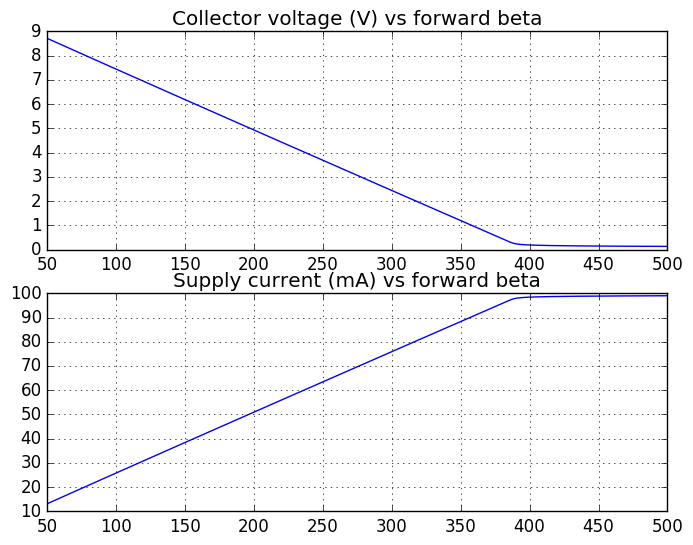

In [9]:
# what happens to the node voltages as the forward Ic/Ib ratio parameter (βf) varies?
q1.βf = :βf

params = Parameters(:βf => 50.)

βf_range = 50.:1.:500.
cop = dc_sweep(circ, :βf, βf_range, params)

# plot the output voltage, and also plot the current through VCC
subplot(2, 1, 1)
grid(b=true, which="major")
title("Collector voltage (V) vs forward beta")
plot(βf_range, cop[q1.pC])
subplot(2, 1, 2)
title("Supply current (mA) vs forward beta")
grid(b=true, which="major")
plot(βf_range, 1e+3 * cop[vcc]);

The transistor is in the forward active region up until $\beta_f = 400$, beyond which the transistor is saturated.

Now, let's add a small signal AC voltage source at the base of the transistor, and plot the collector voltage against the base (input) voltage:

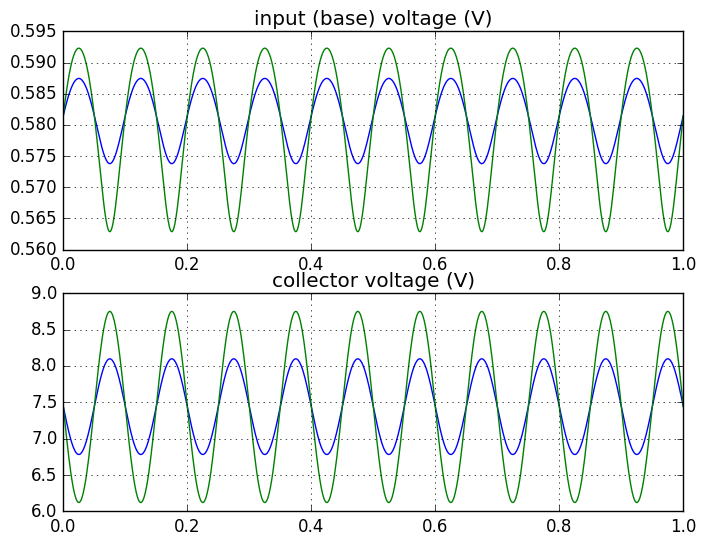

In [10]:
# first, change βf back to a number
q1.βf = 100.

disconnect!(circ, q1.pB)

# 500 mV, 10 Hz
vin = VoltageSource(:(0.5*sin(2π*10.*t)))

connect!(circ, vin.pLow, rb1.p2)
connect!(circ, vin.pHigh, q1.pB)

trange = 0.:0.001:1.
cop = trans_exp(circ, trange)

# let's do the same thing again, with a larger input signal - we should see some clipping/distortion
vin.V = :(1.0*sin(2π*10.*t))
cop2 = trans_exp(circ, trange)

# plot the results
subplot(2, 1, 1)
grid(b=true, which="major")
title("input (base) voltage (V)")
plot(trange, cop[vin.pHigh])
plot(trange, cop2[vin.pHigh])
subplot(2, 1, 2)
title("collector voltage (V)")
grid(b=true, which="major")
plot(trange, cop[q1.pC]);
plot(trange, cop2[q1.pC]);

Note at this stage there are no capacitors, so there is no dependence on frequency.

### Example 6: NPN BJT circuit with coupling capacitors and small signal input

In the above circuit, the input and output signals are offset by the bias voltages (for example, the collector current voltage oscillates around it's ~7.6 V DC value). We fix this potentially unwanted effect by adding input and output coupling capacitors - they're open circuits in the DC sense, and closed circuits in the high-frequency limit. 

In [11]:
# use the previous circuit, and add in the following:
#  - a capacitively coupled input signal on the base
#  - a capacitively coupled 10kΩ load on the collector

# first, get rid of the input source that's on the base
disconnect!(circ, vin.pHigh)
disconnect!(circ, vin.pLow)

# reconnect the base
connect!(circ, q1.pB, rb1.p2)

# the coupling capacitors - 1μF each
cc_in = Capacitor(1e-6)
cc_out = Capacitor(1e-6)

# input source 40 mV, 200 Hz
f = 200.
vin = VoltageSource(:(0.04*sin(2π*$(f)*t)))

# output load
rl = Resistor(10e+3)

# connect the input
connect!(circ, cc_in.p2, q1.pB)
connect!(circ, cc_in.p1, vin.pHigh)
connect!(circ, vin.pLow, circ.gnd)

# connect the output
connect!(circ, cc_out.p1, q1.pC)
connect!(circ, cc_out.p2, rl.p1, "Vload")
connect!(circ, rl.p2, circ.gnd);

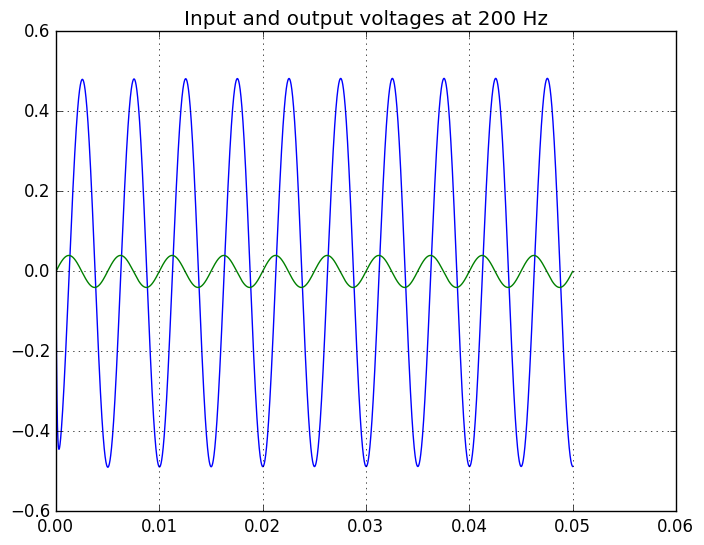

In [12]:
# run transient analysis
trange = 0.:0.000004:0.05
cop_trans = trans_exp(circ, trange)

grid(b=true, which="major")
title("Input and output voltages at 200 Hz")
plot(trange, cop_trans[rl.p1])
plot(trange, cop_trans[vin.pHigh]);

We can see that now, both the input and output voltages are centered around zero (the ground voltage reference). An obvious disadvantage of coupling capacitors is that they introduce a low frequency cutoff (note also the different phase offset):

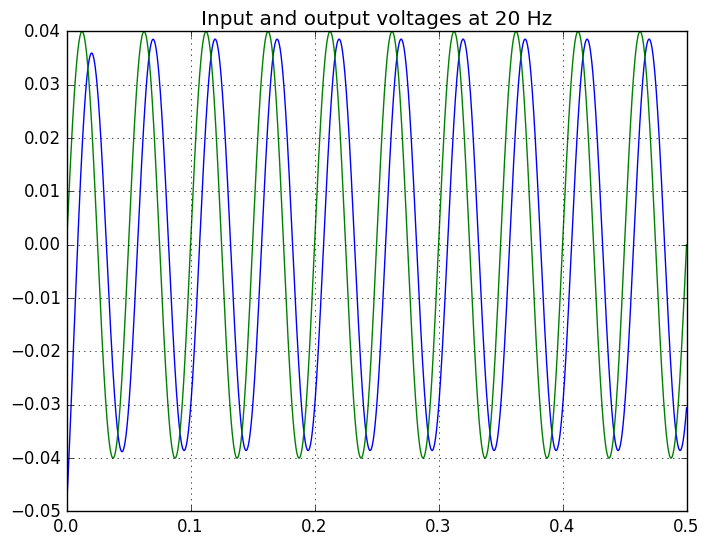

In [13]:
# try a low frequency now 
# input source 40 mV, 20 Hz
f = 20.
vin.V = :(0.04*sin(2π*$(f)*t))

# run transient analysis
trange = 0.:0.00004:0.5
cop_trans = trans_exp(circ, trange)

grid(b=true, which="major")
title("Input and output voltages at 20 Hz")
plot(trange, cop_trans[rl.p1])
plot(trange, cop_trans[vin.pHigh]);

### Example 7: Biased high-pass filter response to an upwards linear chirp

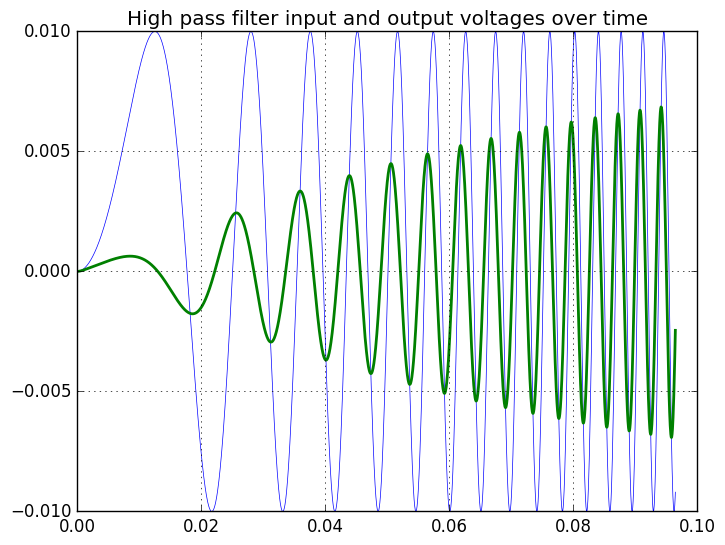

In [54]:
circ = Circuit()
vcc = DCVoltageSource(10.)
r1 = Resistor(10e+3)
r2 = Resistor(10e+3)
c1 = Capacitor(1e-7)
#vin = VoltageSource(:(0.01.*exp(-1000000.*(t-0.01).^2)))
vin = VoltageSource(:(0.01 * sin((100*t)^2)))

connect!(circ, vcc.pLow, circ.gnd)
connect!(circ, vcc.pHigh, r1.p1, "Vcc")
connect!(circ, r1.p2, r2.p1, "Vout")
connect!(circ, r2.p2, circ.gnd)
connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, c1.p1, "Vin")
connect!(circ, c1.p2, r1.p2)

op(circ)

trange = 10.^0.04 - reverse(logspace(0., 0.04, 3000))
cop = trans_exp(circ, trange)

grid(b=true, which="major")
title("High pass filter input and output voltages over time")
plot(trange, cop[vin.pHigh], linewidth = 0.5);
plot(trange, cop[r1.p2] - 5., linewidth = 2.);

Note the output voltage is shifted down 5 V in the plot - if we added a coupling capacitor to the output we wouldn't have to do this, but we'd see a different signal due to that capacitor.

## Part 3: Further Work

### General interface cleanup/organization

The idea of this project is to implement a programmable circuit simulator that's easy and intuitive to use - there's a lot of room for improvement here. For example, there's currently two different types of components for a DC voltage source and a time varying voltage source - but it might be better to have them combied as one component. Further, `connect!(circ, ...)` could certainly be more concise. 

### Improvements to the way 'parameters' are handled

Parameters are currently used as a way to implicitly vary the system to be solved without recompiling $\vec{F}$ and $\vec{J}$ - but they are a bit clumsy, and can't be used with transient analysis right now (but there's no reason they couldn't in theory).

### Improvements to / a replacement for the Newton-Raphson implementation

My implementation (in `newton.jl`) works, but is probably not as robust as, say, the one in the Roots.jl package (for example I am using the absolute error to check for convergence there, but it's probably a better idea to either do some form of scaling or use the relative error).

### Improvements to transient analysis

Currently, the DAE solver in Sundials is used for transient analysis - but I suspect this is using finite differences to compute the Jacobian, because there's no way to supply a Jacobian function with the simplified interface. Instead, using the C interface and providing a Jacobian function could result in a significant performance increase for large circuits.

### Implement MOSFETS

Due to time constraints, MOSFETs were not implemented - however, they would integrate nicely into the current framework and would be fairly easy to implement. The ideal model is simpler than the Ebers-Moll model used for bipolar junction transistors - they use a quadratic IV relation instead of an exponential one, and have a gate current of zero (like a BJT, in the limit $\beta_f \rightarrow \infty$). The quadratic IV relation means we wouldn't need a hack to ensure stability, like the one we required for BJTs and diodes.

### A different approach to generating the $\vec{F}$ and $\vec{J}$ functions

Together, Julia's metaprogramming features and it's JIT compiler facilitate a nice method for generating efficient functions for computing $\vec{F}$ and $\vec{J}$ - but there might be better tools for this purpose. In particular, frameworks for working with computational graphs such as [Theano](http://deeplearning.net/software/theano/) and [TensorFlow](https://www.tensorflow.org/) (typically used for machine learning) would probably work well here too - especially considering their automatic differentiation capabilities.

### Using symbolic operations to generate a direct expression for the Jacobian inverse

Not sure if this would actually be worthwhile - but if the expressions could be simplified sufficiently, each step of Newton-Raphson could potentially be much cheaper (this would be using some kind of symbolic mathematics package like SymPy).

## References


1. M. Holters, U. Zölzer, [A Generalized Method for the Derivation of Non-Linear State-Space Models from Circuit Schematics](http://www.eurasip.org/Proceedings/Eusipco/Eusipco2015/papers/1570103545.pdf), [ACME.jl](https://github.com/HSU-ANT/ACME.jl)